In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [135]:
df = pd.read_csv('datasets/063025-vus10-5min-t3.medium-batch-default.gz')

In [136]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [137]:
df.set_index('timestamp', inplace=True)

In [138]:
df.head()

,metric_name,metric_value,check,error,error_code,expected_response,group,method,name,proto,scenario,service,status,subproto,tls_version,url,extra_tags,metadata
timestamp,,,,,,,,,,,,,,,,,,
2025-07-01 01:05:54,http_reqs,1.000000,NaN,NaN,NaN,True,NaN,POST,http://50.19.55.210:3333/api/pizza,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://50.19.55.210:3333/api/pizza,NaN,NaN
2025-07-01 01:05:54,http_req_duration,189.991696,NaN,NaN,NaN,True,NaN,POST,http://50.19.55.210:3333/api/pizza,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://50.19.55.210:3333/api/pizza,NaN,NaN
2025-07-01 01:05:54,http_req_blocked,90.851503,NaN,NaN,NaN,True,NaN,POST,http://50.19.55.210:3333/api/pizza,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://50.19.55.210:3333/api/pizza,NaN,NaN
2025-07-01 01:05:54,http_req_connecting,90.823427,NaN,NaN,NaN,True,NaN,POST,http://50.19.55.210:3333/api/pizza,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://50.19.55.210:3333/api/pizza,NaN,NaN
2025-07-01 01:05:54,http_req_tls_handshaking,0.000000,NaN,NaN,NaN,True,NaN,POST,http://50.19.55.210:3333/api/pizza,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://50.19.55.210:3333/api/pizza,NaN,NaN


In [139]:
df_rd = df[df['metric_name'] == 'http_req_duration']

In [140]:
Q1 = df_rd['metric_value'].quantile(0.25)
Q3 = df_rd['metric_value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_rd = df_rd[(df_rd['metric_value'] >= lower_bound) & (df_rd['metric_value'] <= upper_bound)]

In [147]:
df_rd.head()

,metric_name,metric_value,check,error,error_code,expected_response,group,method,name,proto,scenario,service,status,subproto,tls_version,url,extra_tags,metadata
timestamp,,,,,,,,,,,,,,,,,,
2025-07-01 01:05:54,http_req_duration,189.991696,NaN,NaN,NaN,True,NaN,POST,http://50.19.55.210:3333/api/pizza,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://50.19.55.210:3333/api/pizza,NaN,NaN
2025-07-01 01:05:54,http_req_duration,201.167765,NaN,NaN,NaN,True,NaN,POST,http://50.19.55.210:3333/api/pizza,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://50.19.55.210:3333/api/pizza,NaN,NaN
2025-07-01 01:05:54,http_req_duration,202.294915,NaN,NaN,NaN,True,NaN,POST,http://50.19.55.210:3333/api/pizza,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://50.19.55.210:3333/api/pizza,NaN,NaN
2025-07-01 01:05:54,http_req_duration,222.462189,NaN,NaN,NaN,True,NaN,POST,http://50.19.55.210:3333/api/pizza,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://50.19.55.210:3333/api/pizza,NaN,NaN
2025-07-01 01:05:54,http_req_duration,235.451258,NaN,NaN,NaN,True,NaN,POST,http://50.19.55.210:3333/api/pizza,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://50.19.55.210:3333/api/pizza,NaN,NaN


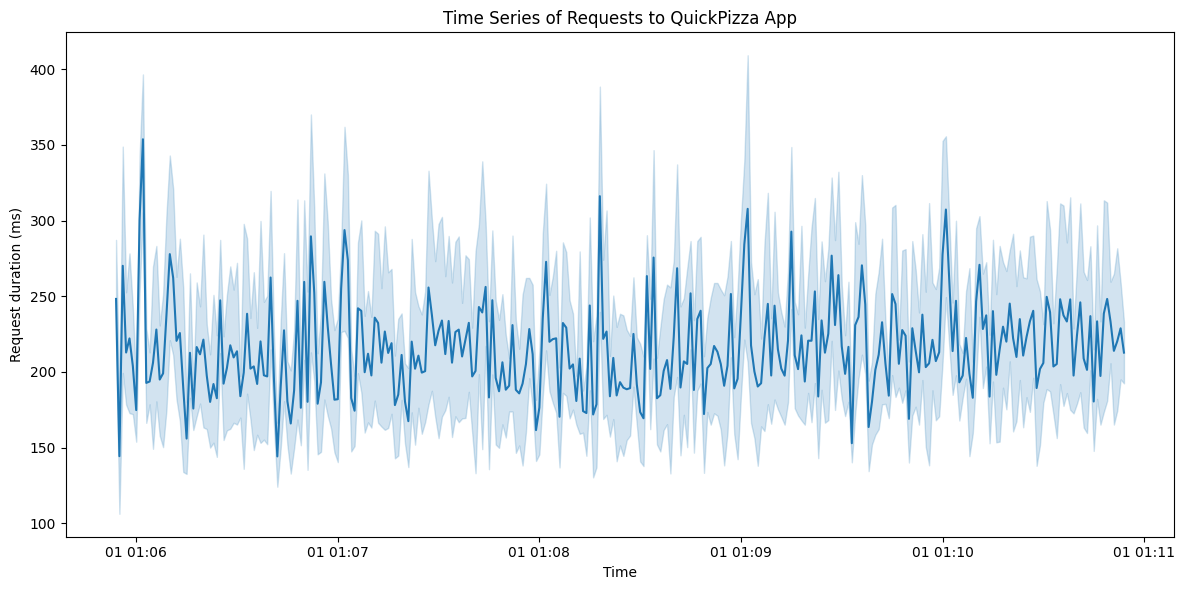

In [142]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_rd, x='timestamp', y='metric_value')
plt.title('Time Series of Requests to QuickPizza App')
plt.xlabel('Time')
plt.ylabel('Request duration (ms)')
plt.tight_layout()
plt.show()

## Grouping the data by a time window

In [149]:
df_rd_grouped = df_rd.resample('200ms').agg({ 'metric_value': 'mean' })

In [150]:
df_rd_grouped = df_rd_grouped.dropna(subset=['metric_value'])

In [151]:
df_rd_grouped.head()

,metric_value
timestamp,
2025-07-01 01:05:54,248.248701
2025-07-01 01:05:55,144.395666
2025-07-01 01:05:56,270.131257
2025-07-01 01:05:57,212.868938
2025-07-01 01:05:58,222.179843


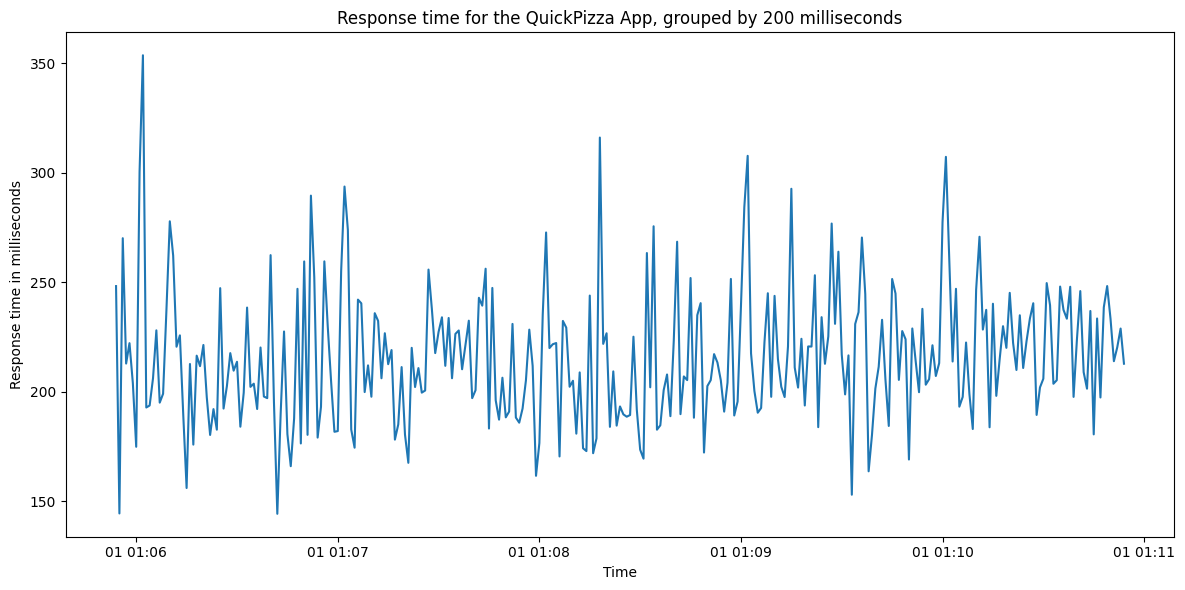

In [152]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_rd_grouped, x='timestamp', y='metric_value')
plt.title('Response time for the QuickPizza App, grouped by 200 milliseconds')
plt.xlabel('Time')
plt.ylabel('Response time in milliseconds')
plt.tight_layout()
plt.show()